In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns
sns.set_style('white')

In [2]:
import easydict
from glob import glob
import pandas as pd
import os
from tqdm import tqdm
import cv2
import re
from joblib import Parallel, delayed
import pickle
import numpy as np
import json
import pydicom as dicom
from collections import defaultdict
import xml.dom.minidom
import xml.etree.ElementTree as et

In [3]:
import torch
import torchvision
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

In [4]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import convertor_utils as cus
from src.utils import visualisation as vs
from src.models.albunet import AlbuNet

from src.modules import losses as ls
from src.modules import dataset as ds
from src.modules import lr_scheduler as lrs
from src.modules import augmentations as augs
from src.modules import learner as lrn

%load_ext autoreload
%autoreload 2

In [5]:
# os.environ["CUDA_VISIBLE_DEVICES"] = ' '.join(map(str, config.DEVICES)),
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.cuda.set_device(config.CUDA_IDX)

In [6]:
annotations = config.ANNOTATIONS.copy()
annotations.head()

,ID,Исследователь,ID Исследования,Кейс,Источник,ID Группы,Группа,Тип Исследования,Часть тела,Модальность снимка,Класс,Файлы,Пути хранения файлов,Протокол,Анкета от нейросети,XML,Файлы разметки,Сегментация толщи железистой ткани,Грудной сосок
0,61769,Iliya Fomenko,90965,244743_20170814,NaN,204,Mammo_seg_2_03_20,NaN,NaN,NaN,NaN,a00001.png\na00003.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi...",NaN,NaN,NaN
1,61770,Iliya Fomenko,90966,605277_20150212,NaN,204,Mammo_seg_2_03_20,NaN,NaN,NaN,NaN,a00001.png\na00002.png\na00003.png\na00004.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi...",NaN,NaN,NaN
2,61771,Iliya Fomenko,90967,993989_20141021,NaN,204,Mammo_seg_2_03_20,NaN,NaN,NaN,NaN,a00001.png\na00002.png\na00003.png\na00004.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi...",NaN,NaN,NaN
3,60419,Iliya Fomenko,90968,8466_20161208,NaN,204,Mammo_seg_2_03_20,NaN,NaN,NaN,NaN,a00001.png\na00002.png\na00003.png\na00004.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi...",NaN,NaN,NaN
4,60468,Iliya Fomenko,90969,53182_20140630,NaN,204,Mammo_seg_2_03_20,NaN,NaN,NaN,NaN,a00001.png\na00002.png\na00003.png\na00004.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi...",NaN,NaN,NaN


In [7]:
annotations = pd.merge(
    annotations[annotations['Группа'] == 'Mammography_shape_02'],
    annotations[annotations['Группа'] == 'Mammo_seg_2_03_20'][['Кейс', 'XML']],
    on='Кейс',
    suffixes=('', '_x')
)
annotations.head()

,ID,Исследователь,ID Исследования,Кейс,Источник,ID Группы,Группа,Тип Исследования,Часть тела,Модальность снимка,Класс,Файлы,Пути хранения файлов,Протокол,Анкета от нейросети,XML,Файлы разметки,Сегментация толщи железистой ткани,Грудной сосок,XML_x
0,66180,Iliya Fomenko,93987,993989_20141021,NaN,220,Mammography_shape_02,NaN,NaN,NaN,NaN,a00001.png\na00002.png\na00003.png\na00004.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""centroid-grudnogo-soska""...",NaN,NaN,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi..."
1,66183,Iliya Fomenko,93988,8466_20161208,NaN,220,Mammography_shape_02,NaN,NaN,NaN,NaN,a00001.png\na00002.png\na00003.png\na00004.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""centroid-grudnogo-soska""...",NaN,NaN,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi..."
2,65678,Iliya Fomenko,93989,621309_20150526,NaN,220,Mammography_shape_02,NaN,NaN,NaN,NaN,a00001.png\na00002.png\na00003.png\na00004.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""centroid-grudnogo-soska""...",NaN,NaN,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi..."
3,65679,Iliya Fomenko,93990,1548867_20171009,NaN,220,Mammography_shape_02,NaN,NaN,NaN,NaN,a00001.png\na00002.png\na00003.png\na00004.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""segmentaciya-tolshya-zhe...",NaN,NaN,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi..."
4,65680,Iliya Fomenko,93991,736736_20131029,NaN,220,Mammography_shape_02,NaN,NaN,NaN,NaN,a00001.png\na00002.png\na00003.png\na00004.png\n,https://label.cmai.tech/storage/app/uploads/pu...,Mammography_seg_2,NaN,"[{""id"":0,""fieldname"":""centroid-grudnogo-soska""...",NaN,NaN,NaN,"[{""id"":0,""fieldname"":""segmentaciya-zhelez"",""fi..."


# Inference

In [8]:
fold = 2
model_name = 'albunet18_fold_{}_best_checkpoint.pth'

In [9]:
checkpoint_path = str(
    config.PATHS.EXPERIMENT_DATA
    /'models'/model_name.format(fold)
)

model = AlbuNet(num_classes=3, is_deconv=True, dropout=.2,
                pretrained=True, encoder=torchvision.models.resnet34(pretrained=True))
model = lrn.to_single_channel(model)
model = lrn.get_model(model, checkpoint=checkpoint_path, devices=config.DEVICES)
learner = lrn.Learner(model, ls.ConditionalBCE(), None, callbacks=[])

Summed over: weight
Overlapped keys: 462


In [8]:
mask_root = config.PATHS.DATA_LOCAL/'roi_segmentation/masks'
os.makedirs(mask_root, exist_ok=True)

postfixes = [
    'tissue',
    'whole',
    'nipple'
]

In [9]:
def build_path(path, mask_root):
    return os.path.join(
        mask_root,
        os.path.basename(path).replace('.png', '_{}.png'))

In [10]:
root = config.PATHS.DATA_LOCAL/'density_estimation/crops'
keys = [
    os.path.basename(p)
    for p in glob(os.path.join(root, '*'))
    if 'segmentation' not in os.path.basename(p)
    if not os.path.isfile(build_path(p, mask_root).format(postfixes[0]))
]

In [12]:
dataset = ds.InferenceDataset(
    root=root, 
    keys=keys)
datagen = torch.utils.data.DataLoader(
    dataset, batch_size=1,
    num_workers=config.WORKERS_NB, 
    collate_fn=ds.inference_collater)

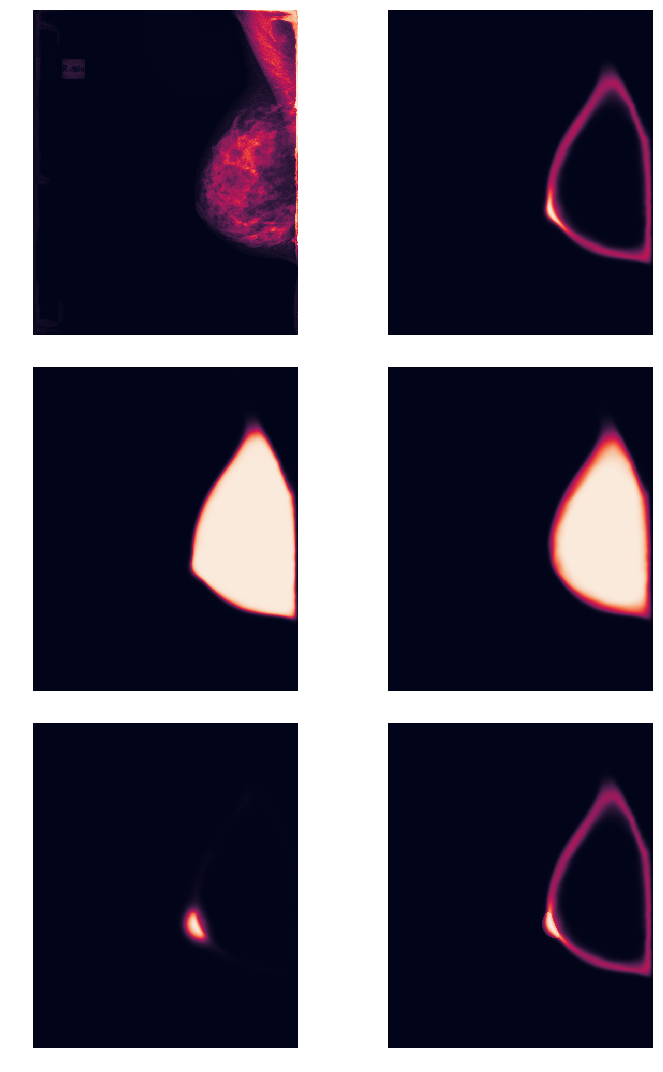

101it [00:45,  2.23it/s]


In [18]:
model.eval()
for i, data in tqdm(enumerate(datagen)):
    predict = ds.infer_on_batch(model, data)
    predict = augs._rotate_mirror_undo(predict)
    shape = data['shape'][0]
    image = data['image'][..., :shape[0], :shape[1]]
    predict = predict[..., :shape[0], :shape[1]]

    path = os.path.join(
        mask_root, data['pid'][0].replace('.png', '_{}.png'))

    for j, el in enumerate(predict):
        cv2.imwrite(path.format(postfixes[j]), (predict[j] * 255).astype(np.int))

    if i % 100 == 0:
        clear_output(wait=True)
        vs.show_segmentations(image[0, 0].numpy(), predict)


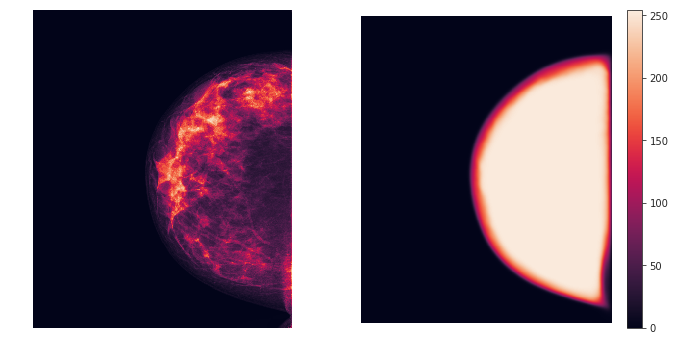

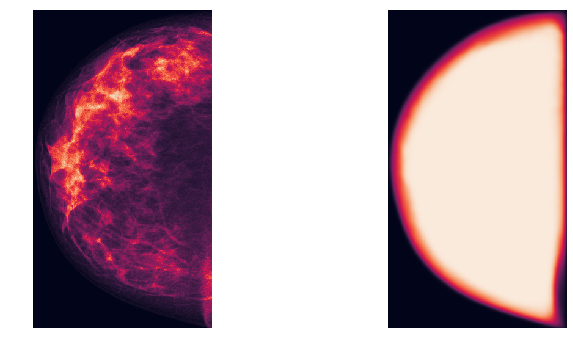

45809it [10:56, 69.77it/s]


In [11]:
cimages_root = config.PATHS.DATA_LOCAL/'cropped/images'
cmasks_root = config.PATHS.DATA_LOCAL/'cropped/masks'
os.makedirs(cimages_root, exist_ok=True)
os.makedirs(cmasks_root, exist_ok=True)
postfix = '_{}.png'.format(postfixes[1])
errors = list()

for i, key in tqdm(enumerate(keys)):
    path = os.path.join(mask_root, key.replace('.png', postfix))
    mask = cv2.imread(path, 0)
    image = cv2.imread(os.path.join(root, key), 0)
    coords = np.array(np.where(mask > 50))
    if coords.shape[1] == 0:
        errors.append(key)
        continue

    y_max, x_max = coords.max(1)
    y_min, x_min = coords.min(1)

    cpath = os.path.join(cimages_root, key)
    cv2.imwrite(cpath, image[y_min: y_max, x_min: x_max])

    path = os.path.join(mask_root, key.replace('.png', '_{}.png'))
    cpath = os.path.join(cmasks_root, key.replace('.png', '_{}.png'))
    for el in postfixes[::-1]:
        mask = cv2.imread(path.format(el), 0)
        cv2.imwrite(cpath.format(el), mask[y_min: y_max, x_min: x_max])

    if i % 2000 == 0:
        clear_output(wait=True)
        vs.show_crops(
            image, mask, (y_min, y_max, x_min, x_max))